In [71]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import os
import json
import random

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed

from keras.utils.vis_utils import plot_model


In [72]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [73]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [74]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


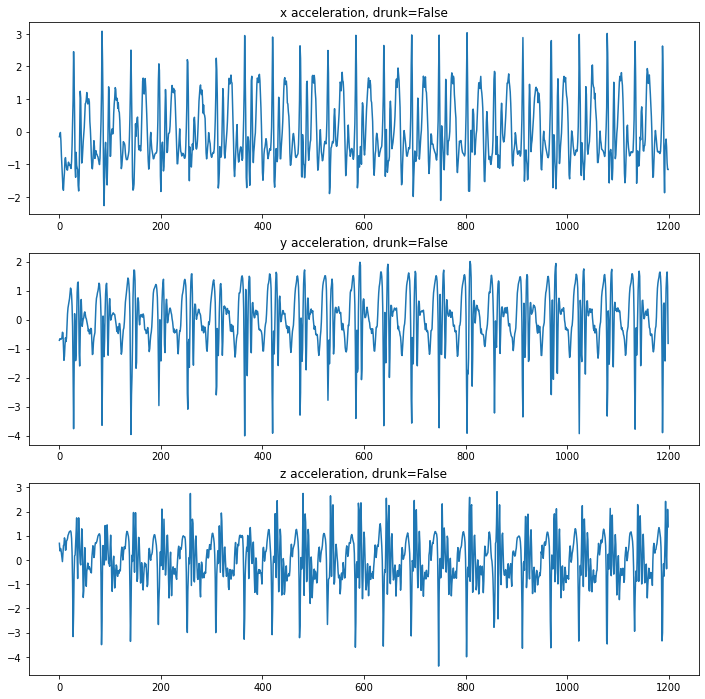

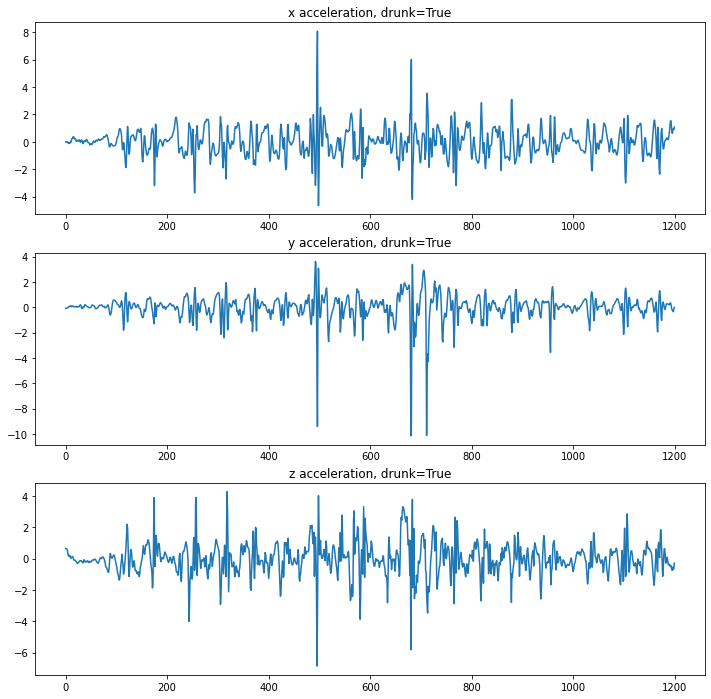

In [75]:
def plot(axes, x, drunk):
    for ax, vals, label in zip(axes, x.T, "xyz"):
        ax.plot([i for i in range(len(vals))], vals)
        ax.set_title(f"{label} acceleration, drunk={drunk}")
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        plot(axes, series, option==1)

plotdata(X, T, y)



Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_138 (Conv1D)         (None, 1198, 64)          640       
                                                                 
 conv1d_139 (Conv1D)         (None, 1196, 64)          12352     
                                                                 
 dropout_87 (Dropout)        (None, 1196, 64)          0         
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, 598, 64)          0         
 g1D)                                                            
                                                                 
 flatten_69 (Flatten)        (None, 38272)             0         
                                                                 
 dense_146 (Dense)           (None, 100)               3827300   
                                                     

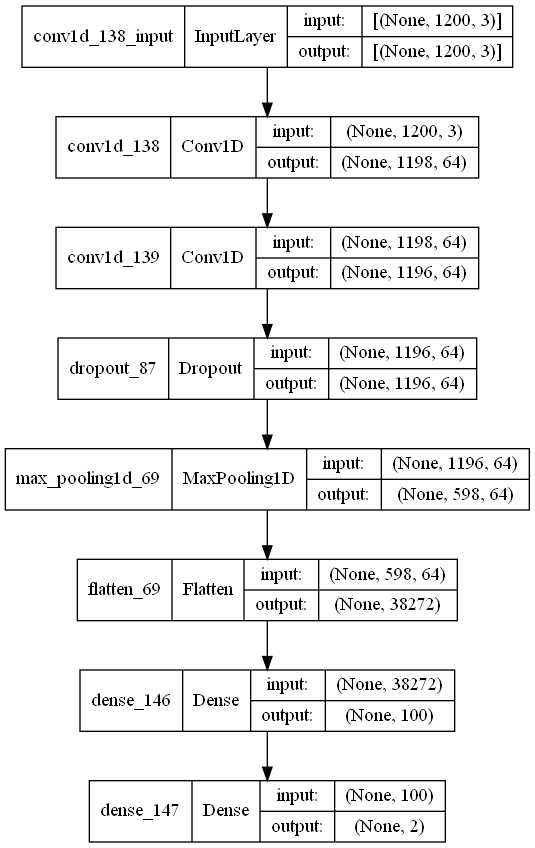

In [76]:
def getCNN1d():
    CNN1d = Sequential()
    CNN1d.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    CNN1d.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    CNN1d.add(Dropout(0.5))
    CNN1d.add(MaxPooling1D(pool_size=2))
    CNN1d.add(Flatten())
    CNN1d.add(Dense(100, activation='relu'))
    CNN1d.add(Dense(2, activation='softmax'))
    CNN1d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return CNN1d

CNN1d = getCNN1d()
print(CNN1d.summary())
plot_model(CNN1d, to_file='CNN1d_plot.png', show_shapes=True, show_layer_names=True)

In [77]:
def getCNN2d():
    CNN2d = Sequential()
    CNN2d.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    CNN2d.add(MaxPooling2D(pool_size=(4,4)))
    CNN2d.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    CNN2d.add(MaxPooling2D(pool_size=(2,2)))
    CNN2d.add(Dense(2, activation='softmax'))
    CNN2d.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return CNN2d

In [78]:
def getCNN1dAlt():
    CNN1dAlt = Sequential()
    CNN1dAlt.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
    CNN1dAlt.add(LSTM(128, input_shape=128))

    CNN1dAlt.add(Conv1D(filters=64, kernel_size=3, strides=2, activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])))
    CNN1dAlt.add(MaxPooling1D(pool_size=2, strides=2))
    CNN1dAlt.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'))
    CNN1dAlt.add(GlobalAveragePooling1D())
    CNN1dAlt.add(BatchNormalization())
    CNN1dAlt.add(Dense(2, activation='softmax'))
    CNN1dAlt.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return CNN1dAlt

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100)               41600     
                                                                 
 dropout_88 (Dropout)        (None, 100)               0         
                                                                 
 dense_148 (Dense)           (None, 100)               10100     
                                                                 
 dense_149 (Dense)           (None, 2)                 202       
                                                                 
Total params: 51,902
Trainable params: 51,902
Non-trainable params: 0
_________________________________________________________________
None


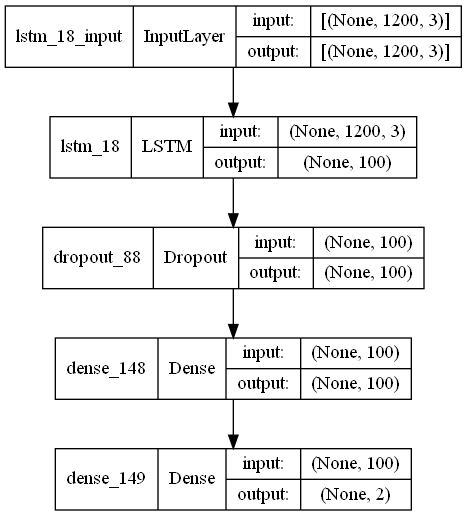

In [79]:
def getRNN():
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    RNN = Sequential()
    RNN.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    RNN.add(Dropout(0.5))
    RNN.add(Dense(100, activation='relu'))
    RNN.add(Dense(n_outputs, activation='softmax'))
    RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return RNN

RNN = getRNN()
print(RNN.summary())
plot_model(RNN, to_file='RNN_plot.png', show_shapes=True, show_layer_names=True)

(387, 1200, 3)
(387, 12, 100, 3)
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_70 (TimeDi  (None, None, 98, 64)     640       
 stributed)                                                      
                                                                 
 time_distributed_71 (TimeDi  (None, None, 96, 64)     12352     
 stributed)                                                      
                                                                 
 time_distributed_72 (TimeDi  (None, None, 96, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_73 (TimeDi  (None, None, 48, 64)     0         
 stributed)                                                      
                                                                 
 time_distributed_74

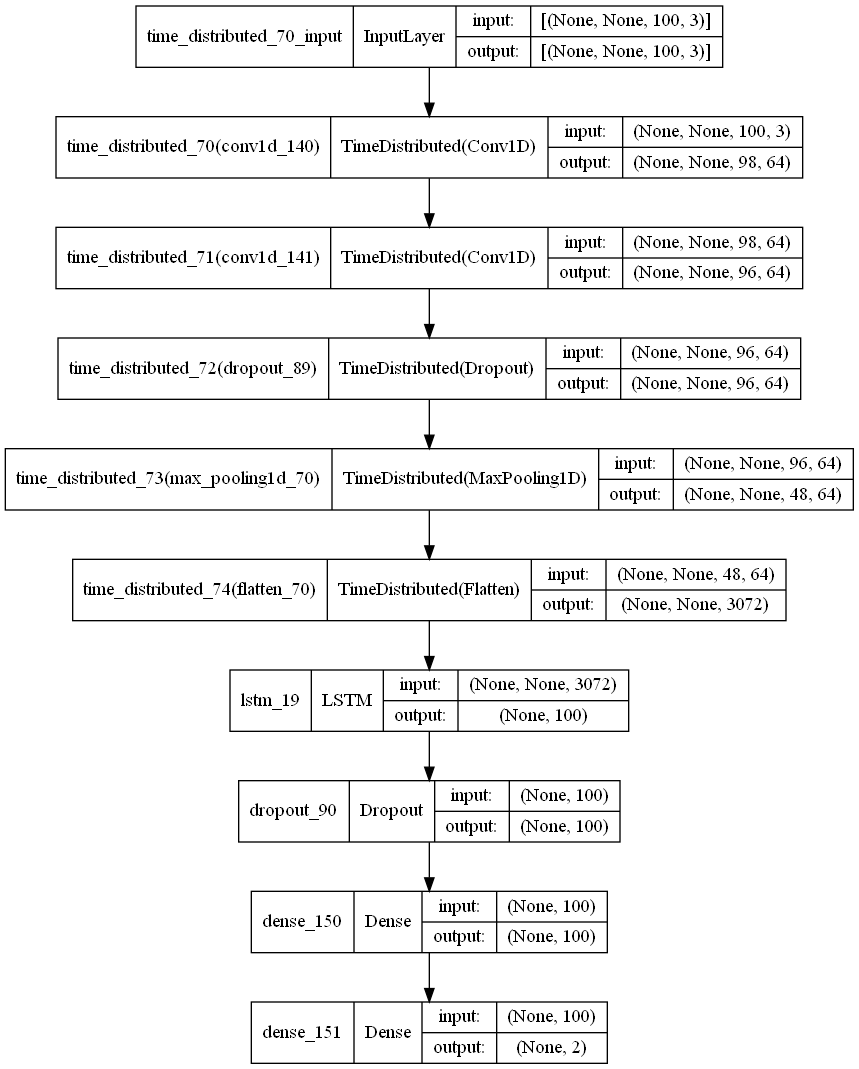

In [80]:
def getLSTM_CNN():
    print(X.shape)
    stepCount = 12 
    length = X.shape[1] // stepCount
    Q = X.reshape((X.shape[0], stepCount, length, X.shape[2]))
    print(Q.shape)
    LSTM_CNN = Sequential()
    LSTM_CNN.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,length,X.shape[2])))
    LSTM_CNN.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    LSTM_CNN.add(TimeDistributed(Dropout(0.5)))
    LSTM_CNN.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    LSTM_CNN.add(TimeDistributed(Flatten()))
    LSTM_CNN.add(LSTM(100))
    LSTM_CNN.add(Dropout(0.5))
    LSTM_CNN.add(Dense(100, activation='relu'))
    LSTM_CNN.add(Dense(y.shape[1], activation='softmax'))

    LSTM_CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return LSTM_CNN

LSTM_CNN = getLSTM_CNN()
print(LSTM_CNN.summary())
plot_model(LSTM_CNN, to_file='LSTM_CNN_plot.png', show_shapes=True, show_layer_names=True)

In [81]:
def fitLSTM_CNN(model, X, y):
    stepCount = 12 
    length = X.shape[1] // stepCount
    X = X.reshape((X.shape[0], stepCount, length, X.shape[2]))

    model.fit(X, y, epochs=6, batch_size=32, verbose=False)

def fitGenericModel(model, X, y):
    model.fit(X, y, epochs=6, batch_size=32, verbose=False)


In [82]:
def predictLSTM_CNN(model, X):
    stepCount = 12 
    length = X.shape[1] // stepCount
    X = X.reshape((X.shape[0], stepCount, length, X.shape[2]))
    return model.predict(X)

def predictGenericModel(model : Sequential, X):
    return model.predict(X)

In [83]:
def trainModels(X, y, modelGetter, modelFitter, repeats=10):
	# repeat experiment
	models = []
	for i in range(repeats):
		print(f"> test {i}")
		model = modelGetter()
		modelFitter(model, X, y)
		models.append(model)
	return models

def predictTestData(models, predictor, X_test):
	predictions = []
	for i, m in enumerate(models):
		#y_pred = m.predict(X_test)
		y_pred = predictor(m, X_test)
		y_pred = y_pred.round()
		predictions.append(y_pred)
	return predictions

def evaluatePredictions(predictions, y):
	scores = []
	for i, y_pred in enumerate(predictions):
		accuracy = metrics.accuracy_score(y, y_pred)
		precision = metrics.precision_score(y, y_pred, average="macro")
		recall = metrics.recall_score(y, y_pred, average="macro")
		
		scores.append([accuracy, precision, recall])
	return scores


In [86]:
# run 1D CNN
models = trainModels(X_train, y_train, getCNN1d, fitGenericModel)

predictions = predictTestData(models, predictGenericModel, X_test)
trainingPredictions = predictTestData(models, predictGenericModel,X_train)
scores = evaluatePredictions(predictions, y_test)
trainingScores = evaluatePredictions(trainingPredictions, y_train)

> test 0
> test 1
> test 2
> test 3
> test 4
> test 5
> test 6
> test 7
> test 8
> test 9


C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# run the experiment
models = trainModels(X_train, y_train, getLSTM_CNN, fitLSTM_CNN)

predictions = predictTestData(models, predictLSTM_CNN, X_test)
trainingPredictions = predictTestData(models, predictLSTM_CNN,X_train)
scores = evaluatePredictions(predictions, y_test)
trainingScores = evaluatePredictions(trainingPredictions, y_train)

> test 0
(387, 1200, 3)
(387, 12, 100, 3)
> test 1
(387, 1200, 3)
(387, 12, 100, 3)
> test 2
(387, 1200, 3)
(387, 12, 100, 3)
> test 3
(387, 1200, 3)
(387, 12, 100, 3)
> test 4
(387, 1200, 3)
(387, 12, 100, 3)
> test 5
(387, 1200, 3)
(387, 12, 100, 3)
> test 6
(387, 1200, 3)
(387, 12, 100, 3)
> test 7
(387, 1200, 3)
(387, 12, 100, 3)
> test 8
(387, 1200, 3)
(387, 12, 100, 3)
> test 9
(387, 1200, 3)
(387, 12, 100, 3)


In [89]:
def summarize_results(scores):
	s = np.array(scores)
	#m, s = np.mean(scores), np.std(scores)
	chosenMetrics = ["accuracy ", 
					 "precision", 
					 "recall   "]
	mean = s.mean(axis=0)
	std = s.std(axis=0)
	for m, v, d in zip(chosenMetrics, mean, std):
		print(f"{m}: {v :.3f} (+- {d :.3f})")
	#print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

print("test data:")
summarize_results(scores)
print("")
print("training data:")
summarize_results(trainingScores)

test data:
accuracy : 0.851 (+- 0.026)
precision: 0.863 (+- 0.019)
recall   : 0.842 (+- 0.035)

training data:
accuracy : 0.989 (+- 0.018)
precision: 0.990 (+- 0.014)
recall   : 0.986 (+- 0.022)


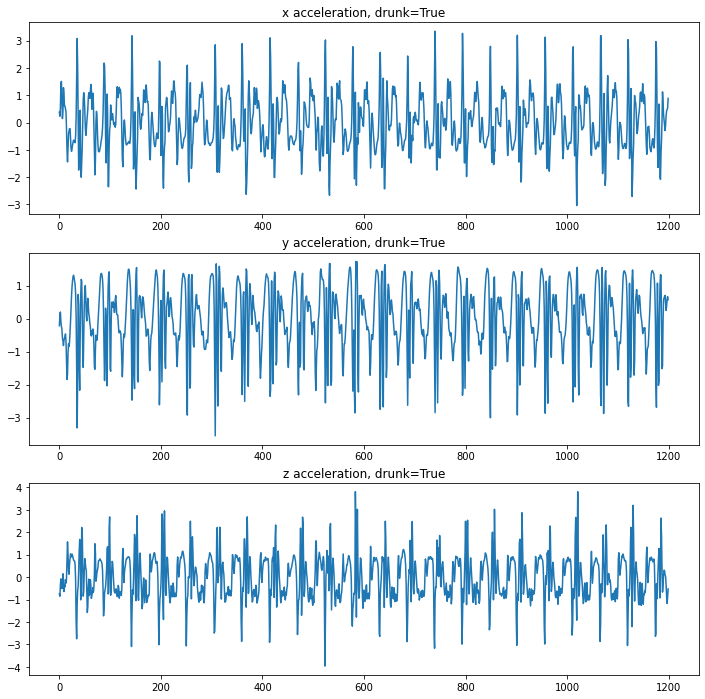

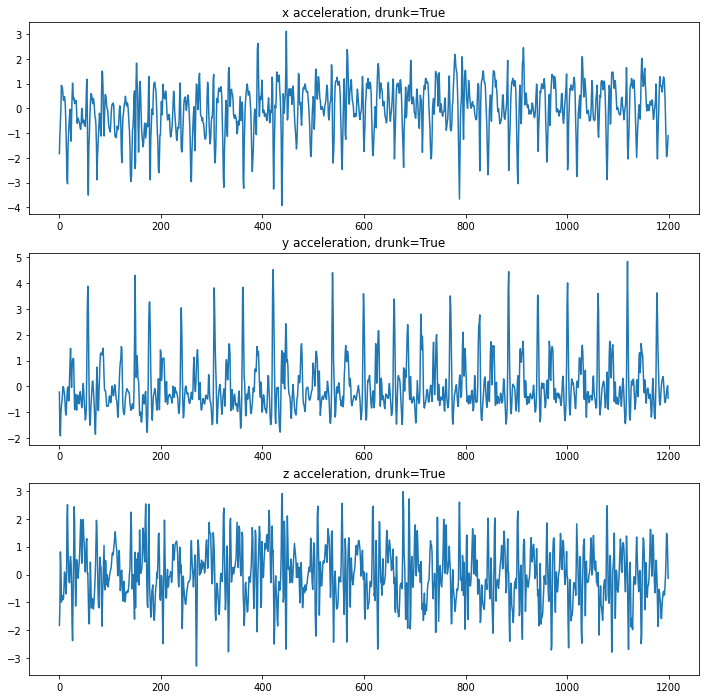

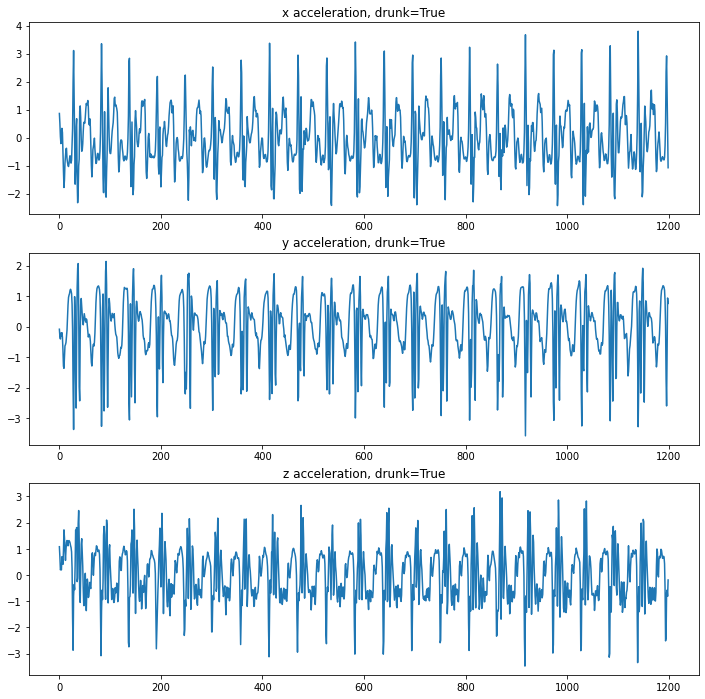

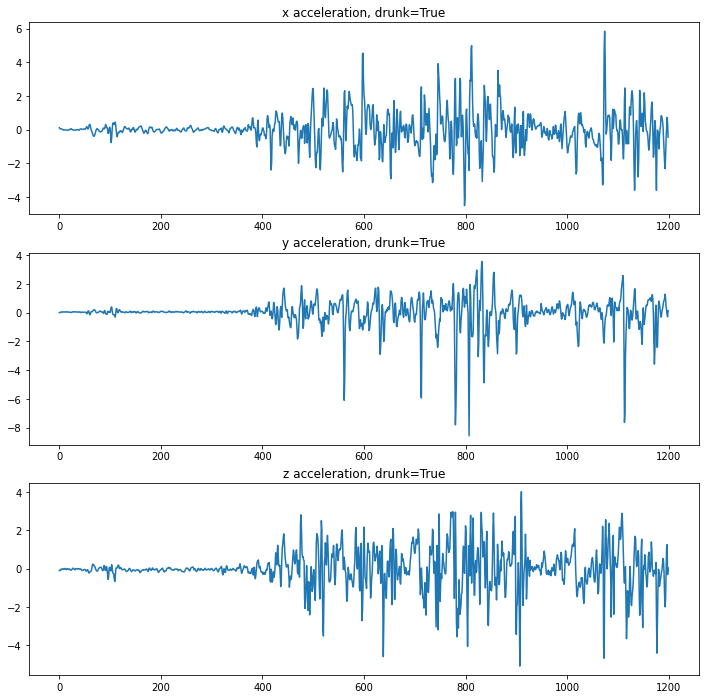

In [90]:
def getFalseNegatives(X, prediction, y):
    grndPositives = y.T[0] == 1
    predNegatives = prediction.T[1] == 1
    falseNegatives = np.logical_and(grndPositives, predNegatives)
    return X[falseNegatives]

falseNegatives = getFalseNegatives(X_test, predictions[0], y_test)


for n in falseNegatives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, True)

6


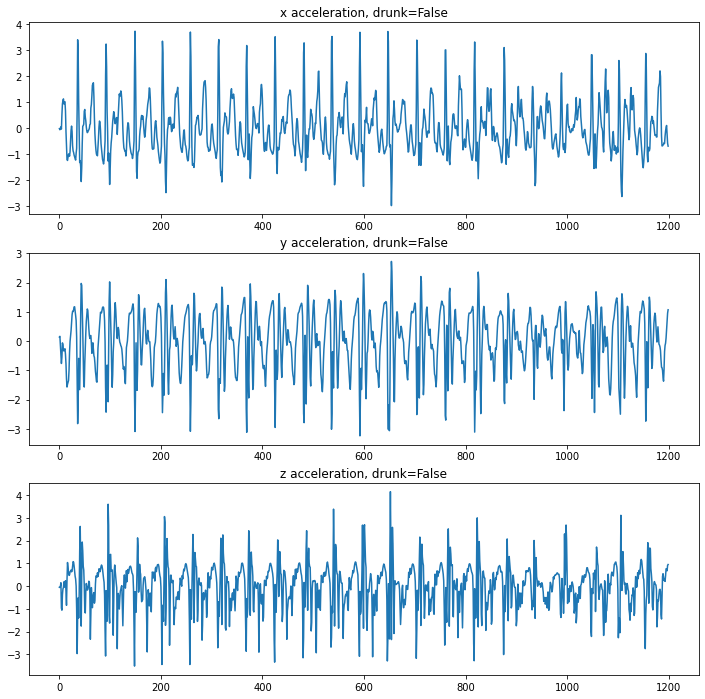

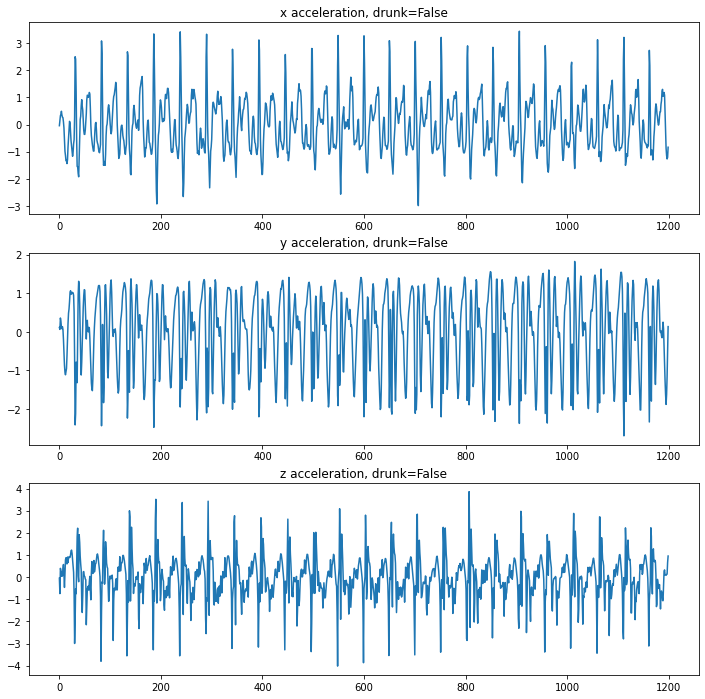

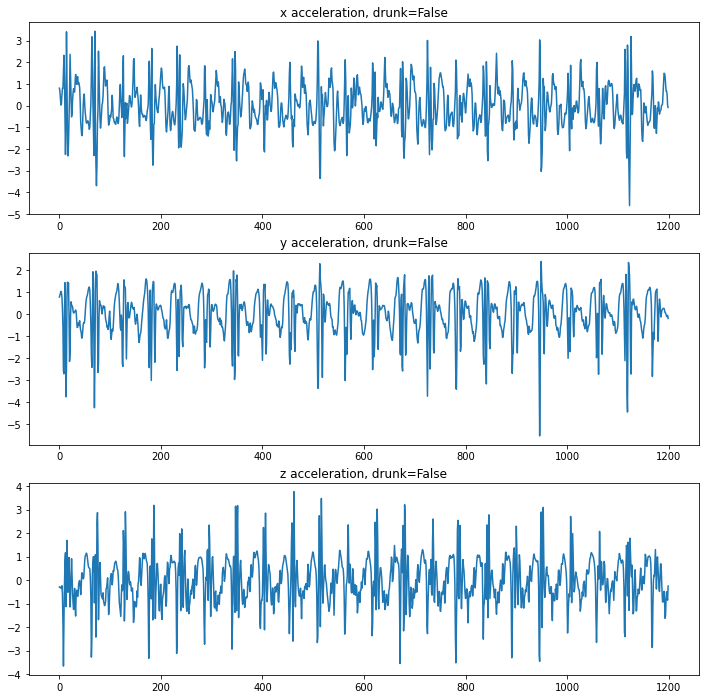

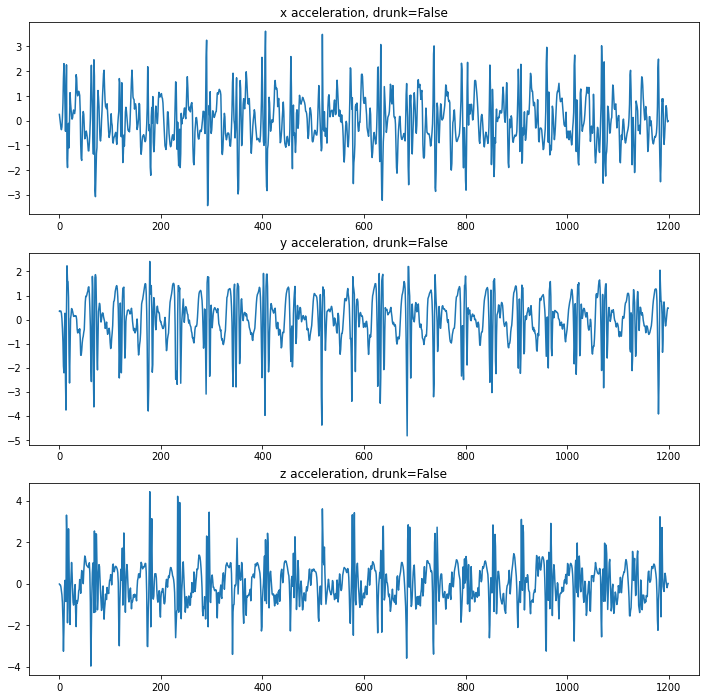

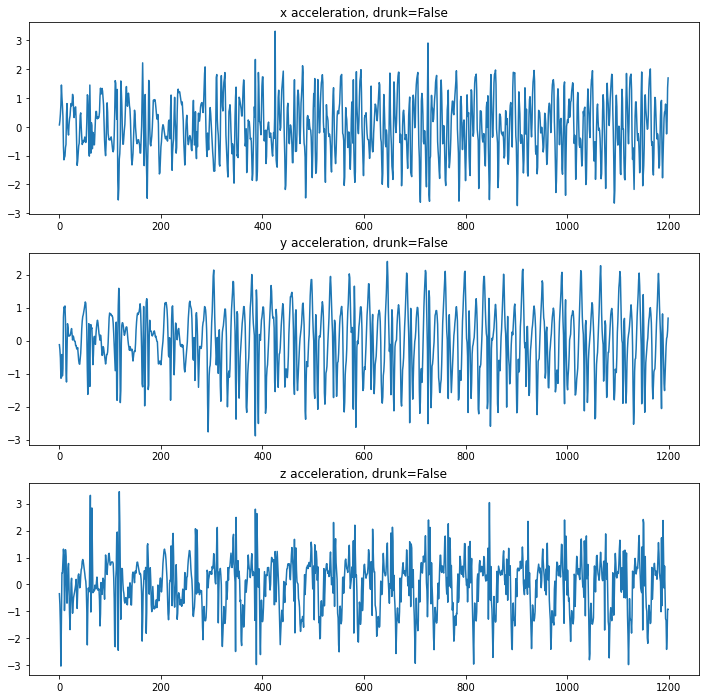

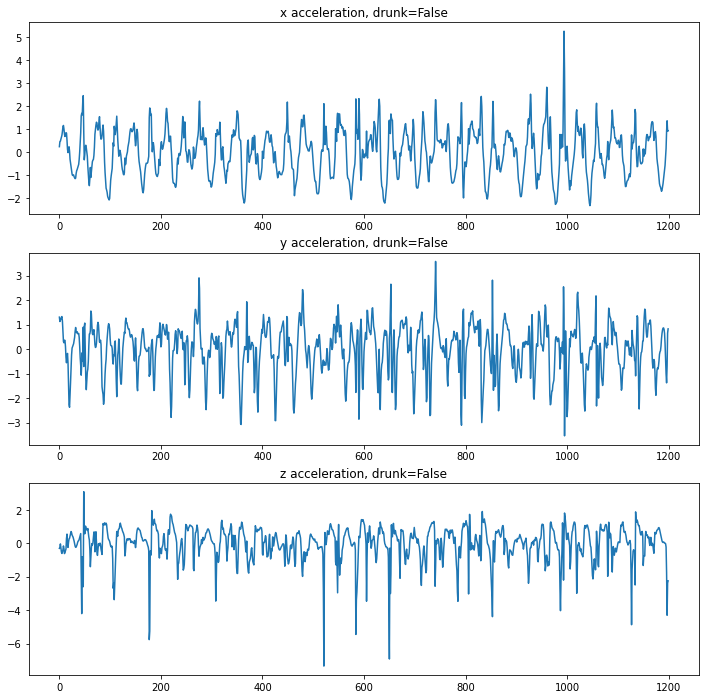

In [92]:
def getFalsePosetives(X, prediction, y):
    grndNegatives = y.T[1] == 1
    predPositives = prediction.T[0] == 1
    falsePosetives = np.logical_and(grndNegatives, predPositives)
    return X[falsePosetives]

falsePosetives = getFalsePosetives(X_test, predictions[0], y_test)
print(len(falsePosetives))

for n in falsePosetives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, False)